# Blood Cell type Classification 

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model 
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
import imutils


C:\Users\sreer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sreer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sreer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sreer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# Load Data


In [2]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (120,120)

In [3]:
def load_data():

    datasets = ['dataset2-master/dataset2-master/images/TRAIN/','dataset2-master/dataset2-master/images/TEST' ]
    images = []
    labels = []

    count =0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3


            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                grayscale = cv2.GaussianBlur(image1, (1, 1), 0)
                edge = cv2.Canny(grayscale, 100, 400)
                edge = cv2.dilate(edge, None, iterations=1)
                edgedImage = cv2.erode(edge, None, iterations=1)
                contours = cv2.findContours(edgedImage.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                contours = imutils.grab_contours(contours)
                edgedContours = sorted(contours, key=lambda x: cv2.contourArea(x))
                edgedBoxes = []
                centers = []
                for contour in edgedContours:
                    box = cv2.minAreaRect(contour)
                    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
                    box = np.array(box, dtype="int")
                    (tl, tr, br, bl) = box
                    if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
                        edgedBoxes.append(box)
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                image[mask==0] = 0
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [4]:
images, labels = load_data()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [00:02<00:00, 213.75it/s]


## Train-Test split

In [5]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

# Data Exploration 

In [6]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print(n_train, n_val, n_test)

9716 1215 1215


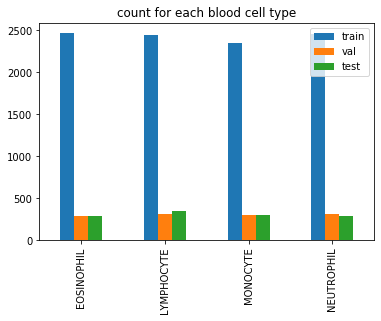

In [7]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()
plt.title("count for each blood cell type")
plt.show()

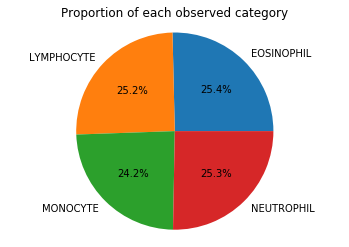

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

9716


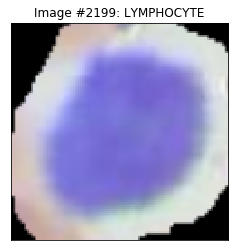

In [10]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

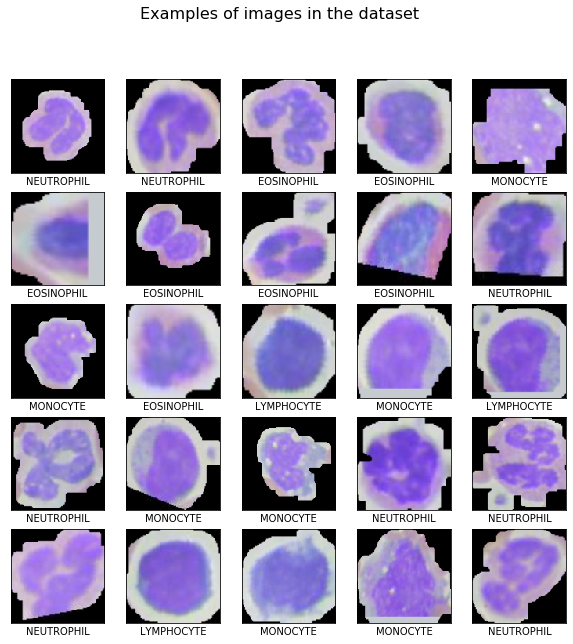

In [11]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

# VGG16

In [12]:
model1 = Sequential()

# First Conv block
model1.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
model1.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv block
model1.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Third Conv block
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Forth Conv block
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

# Fifth Conv block 
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))


# FC layer 
model1.add(Flatten())
model1.add(Dense(units = 512 , activation = 'tanh'))
model1.add(Dropout(0.5))
model1.add(Dense(units = 128 , activation = 'tanh'))
model1.add(Dropout(0.2))
model1.add(Dense(units = 64 , activation = 'tanh'))
model1.add(Dropout(0.1))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='vgg16.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# Train
history1 = model1.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 30, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 120, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 60, 60, 32)        688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 60, 60, 32)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)      


Epoch 00019: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 20/30
9716/9716 [==============================] - 563s 58ms/step - loss: 0.0470 - accuracy: 0.9841 - val_loss: 0.0708 - val_accuracy: 0.9745
Epoch 21/30
9716/9716 [==============================] - 526s 54ms/step - loss: 0.0431 - accuracy: 0.9853 - val_loss: 0.0711 - val_accuracy: 0.9745
Epoch 22/30
9716/9716 [==============================] - 502s 52ms/step - loss: 0.0410 - accuracy: 0.9854 - val_loss: 0.0707 - val_accuracy: 0.9753
Epoch 23/30
9716/9716 [==============================] - 459s 47ms/step - loss: 0.0472 - accuracy: 0.9822 - val_loss: 0.0715 - val_accuracy: 0.9745
Epoch 24/30
9716/9716 [==============================] - 458s 47ms/step - loss: 0.0439 - accuracy: 0.9844 - val_loss: 0.0701 - val_accuracy: 0.9745
Epoch 25/30
9716/9716 [==============================] - 454s 47ms/step - loss: 0.0425 - accuracy: 0.9841 - val_loss: 0.0713 - val_accuracy: 0.9737
Epoch 26/30
9716/9716 [========================

# Evaluating performance

In [13]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(30)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

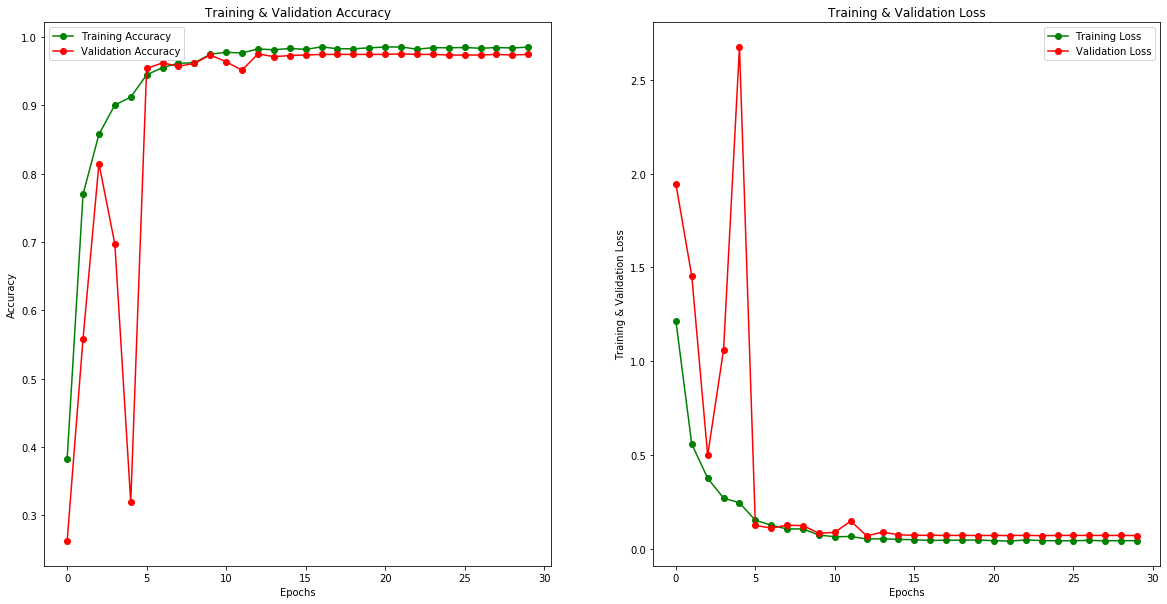

In [14]:
plot_accuracy_loss_chart(history1)

In [15]:

results = model1.evaluate(test_images, test_labels)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


results = model1.evaluate(val_images, val_labels)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%")

results = model1.evaluate(train_images, train_labels)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

1215/1215 [==============================] - 19s 16ms/step
Loss of the model  is - test  0.08675709643359047
Accuracy of the model is - test 96.95473313331604 %
1215/1215 [==============================] - 18s 15ms/step
Loss of the model  is - val  0.07064635452465633
Accuracy of the model is - val 97.44855761528015 %
9716/9716 [==============================] - 144s 15ms/step
Loss of the model  is - train  0.022247466368314314
Accuracy of the model is - train 99.16632175445557 %


In [16]:
model1.save('Bloodcell_Classification_Model1_VGG16.h5')

In [17]:
from sklearn.metrics import classification_report

predictions = model1.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([3, 2, 2, 0, 3, 2, 1, 0, 1, 3, 1, 1, 1, 3, 0], dtype=int64)

In [18]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.92      0.97      0.94       287
LYMPHOCYTE (Class 1)       0.99      1.00      0.99       344
  MONOCYTE (Class 2)       0.99      0.98      0.99       296
NEUTROPHIL (Class 3)       0.97      0.93      0.95       288

            accuracy                           0.97      1215
           macro avg       0.97      0.97      0.97      1215
        weighted avg       0.97      0.97      0.97      1215



In [19]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,277,2,1,7
1,1,343,0,0
2,4,1,291,0
3,19,1,1,267


In [20]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    


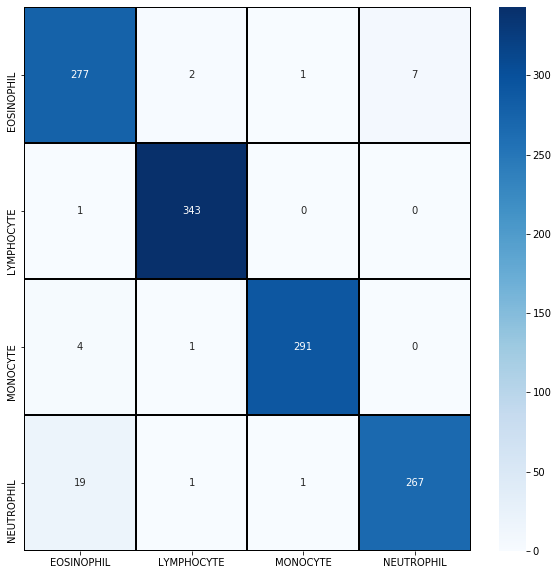

In [21]:
plot_confusion_matrix(cm)

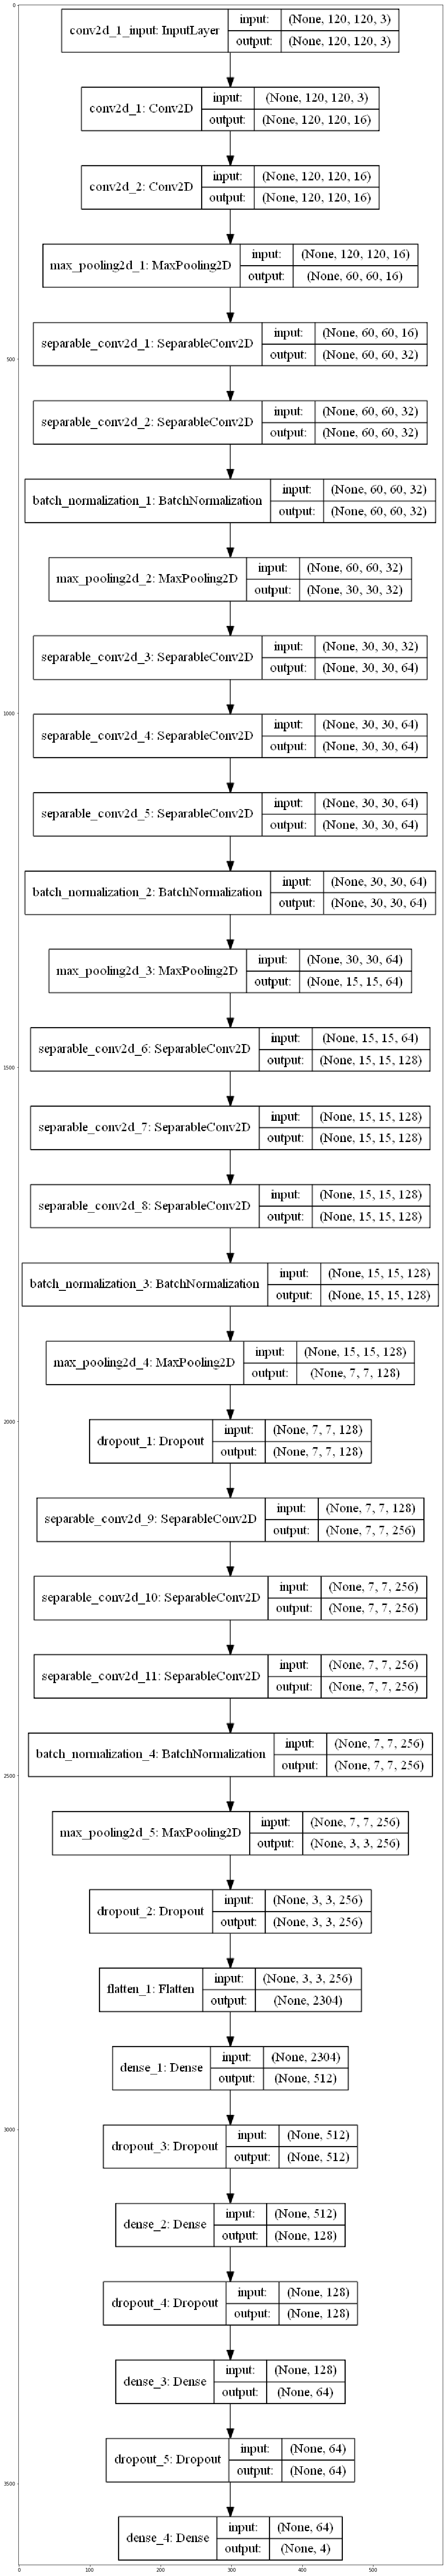

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(100,100))
plt.imshow(plt.imread('model1_plot.png'))

##  CNN Model

In [27]:
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(120,120,3),strides=1))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation='softmax'))
model2.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model2.summary()

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='CNN_model2.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# Train
history2 = model2.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 30, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 118, 118, 32)      896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 58, 58, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 58, 58, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 215296)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               27558016  
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)              

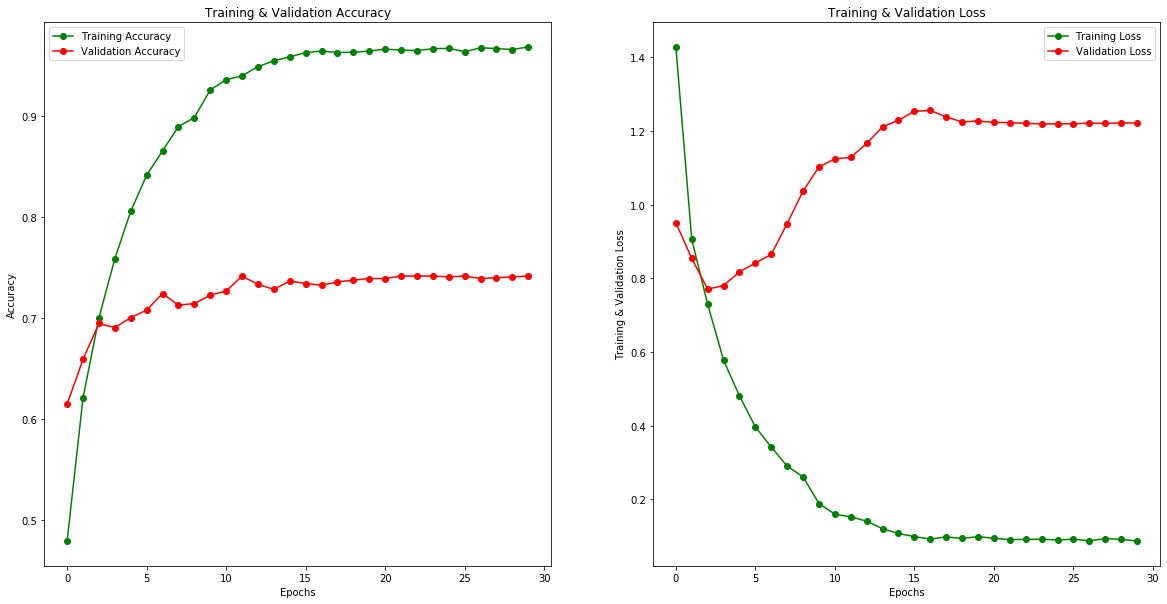

In [28]:
plot_accuracy_loss_chart(history2)

In [29]:
results = model2.evaluate(test_images, test_labels)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


results = model2.evaluate(val_images, val_labels)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%")

results = model2.evaluate(train_images, train_labels)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

1215/1215 [==============================] - 12s 10ms/step
Loss of the model  is - test  1.2200224236696344
Accuracy of the model is - test 73.90946745872498 %
1215/1215 [==============================] - 12s 10ms/step
Loss of the model  is - val  1.2215847102212318
Accuracy of the model is - val 74.15637969970703 %
9716/9716 [==============================] - 107s 11ms/step
Loss of the model  is - train  0.012994277522201007
Accuracy of the model is - train 99.79415535926819 %


In [30]:
model2.save('Bloodcell_Classification_Model2_CNN.h5')

In [31]:
from sklearn.metrics import classification_report

predictions2 = model2.predict(test_images)
predictions2 = np.argmax(predictions2,axis=1)
predictions2[:15]

array([3, 2, 0, 0, 2, 2, 1, 0, 1, 3, 1, 1, 1, 3, 0], dtype=int64)

In [32]:
print(classification_report(
    test_labels, 
    predictions2, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.60      0.63      0.62       287
LYMPHOCYTE (Class 1)       0.90      0.88      0.89       344
  MONOCYTE (Class 2)       0.78      0.80      0.79       296
NEUTROPHIL (Class 3)       0.65      0.61      0.63       288

            accuracy                           0.74      1215
           macro avg       0.73      0.73      0.73      1215
        weighted avg       0.74      0.74      0.74      1215



In [33]:
cm = confusion_matrix(test_labels, predictions2)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,181,16,27,63
1,15,303,12,14
2,38,3,238,17
3,66,16,30,176


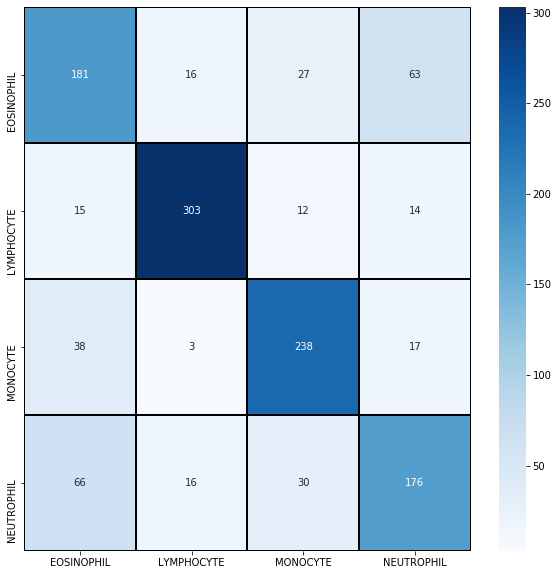

In [34]:
plot_confusion_matrix(cm)

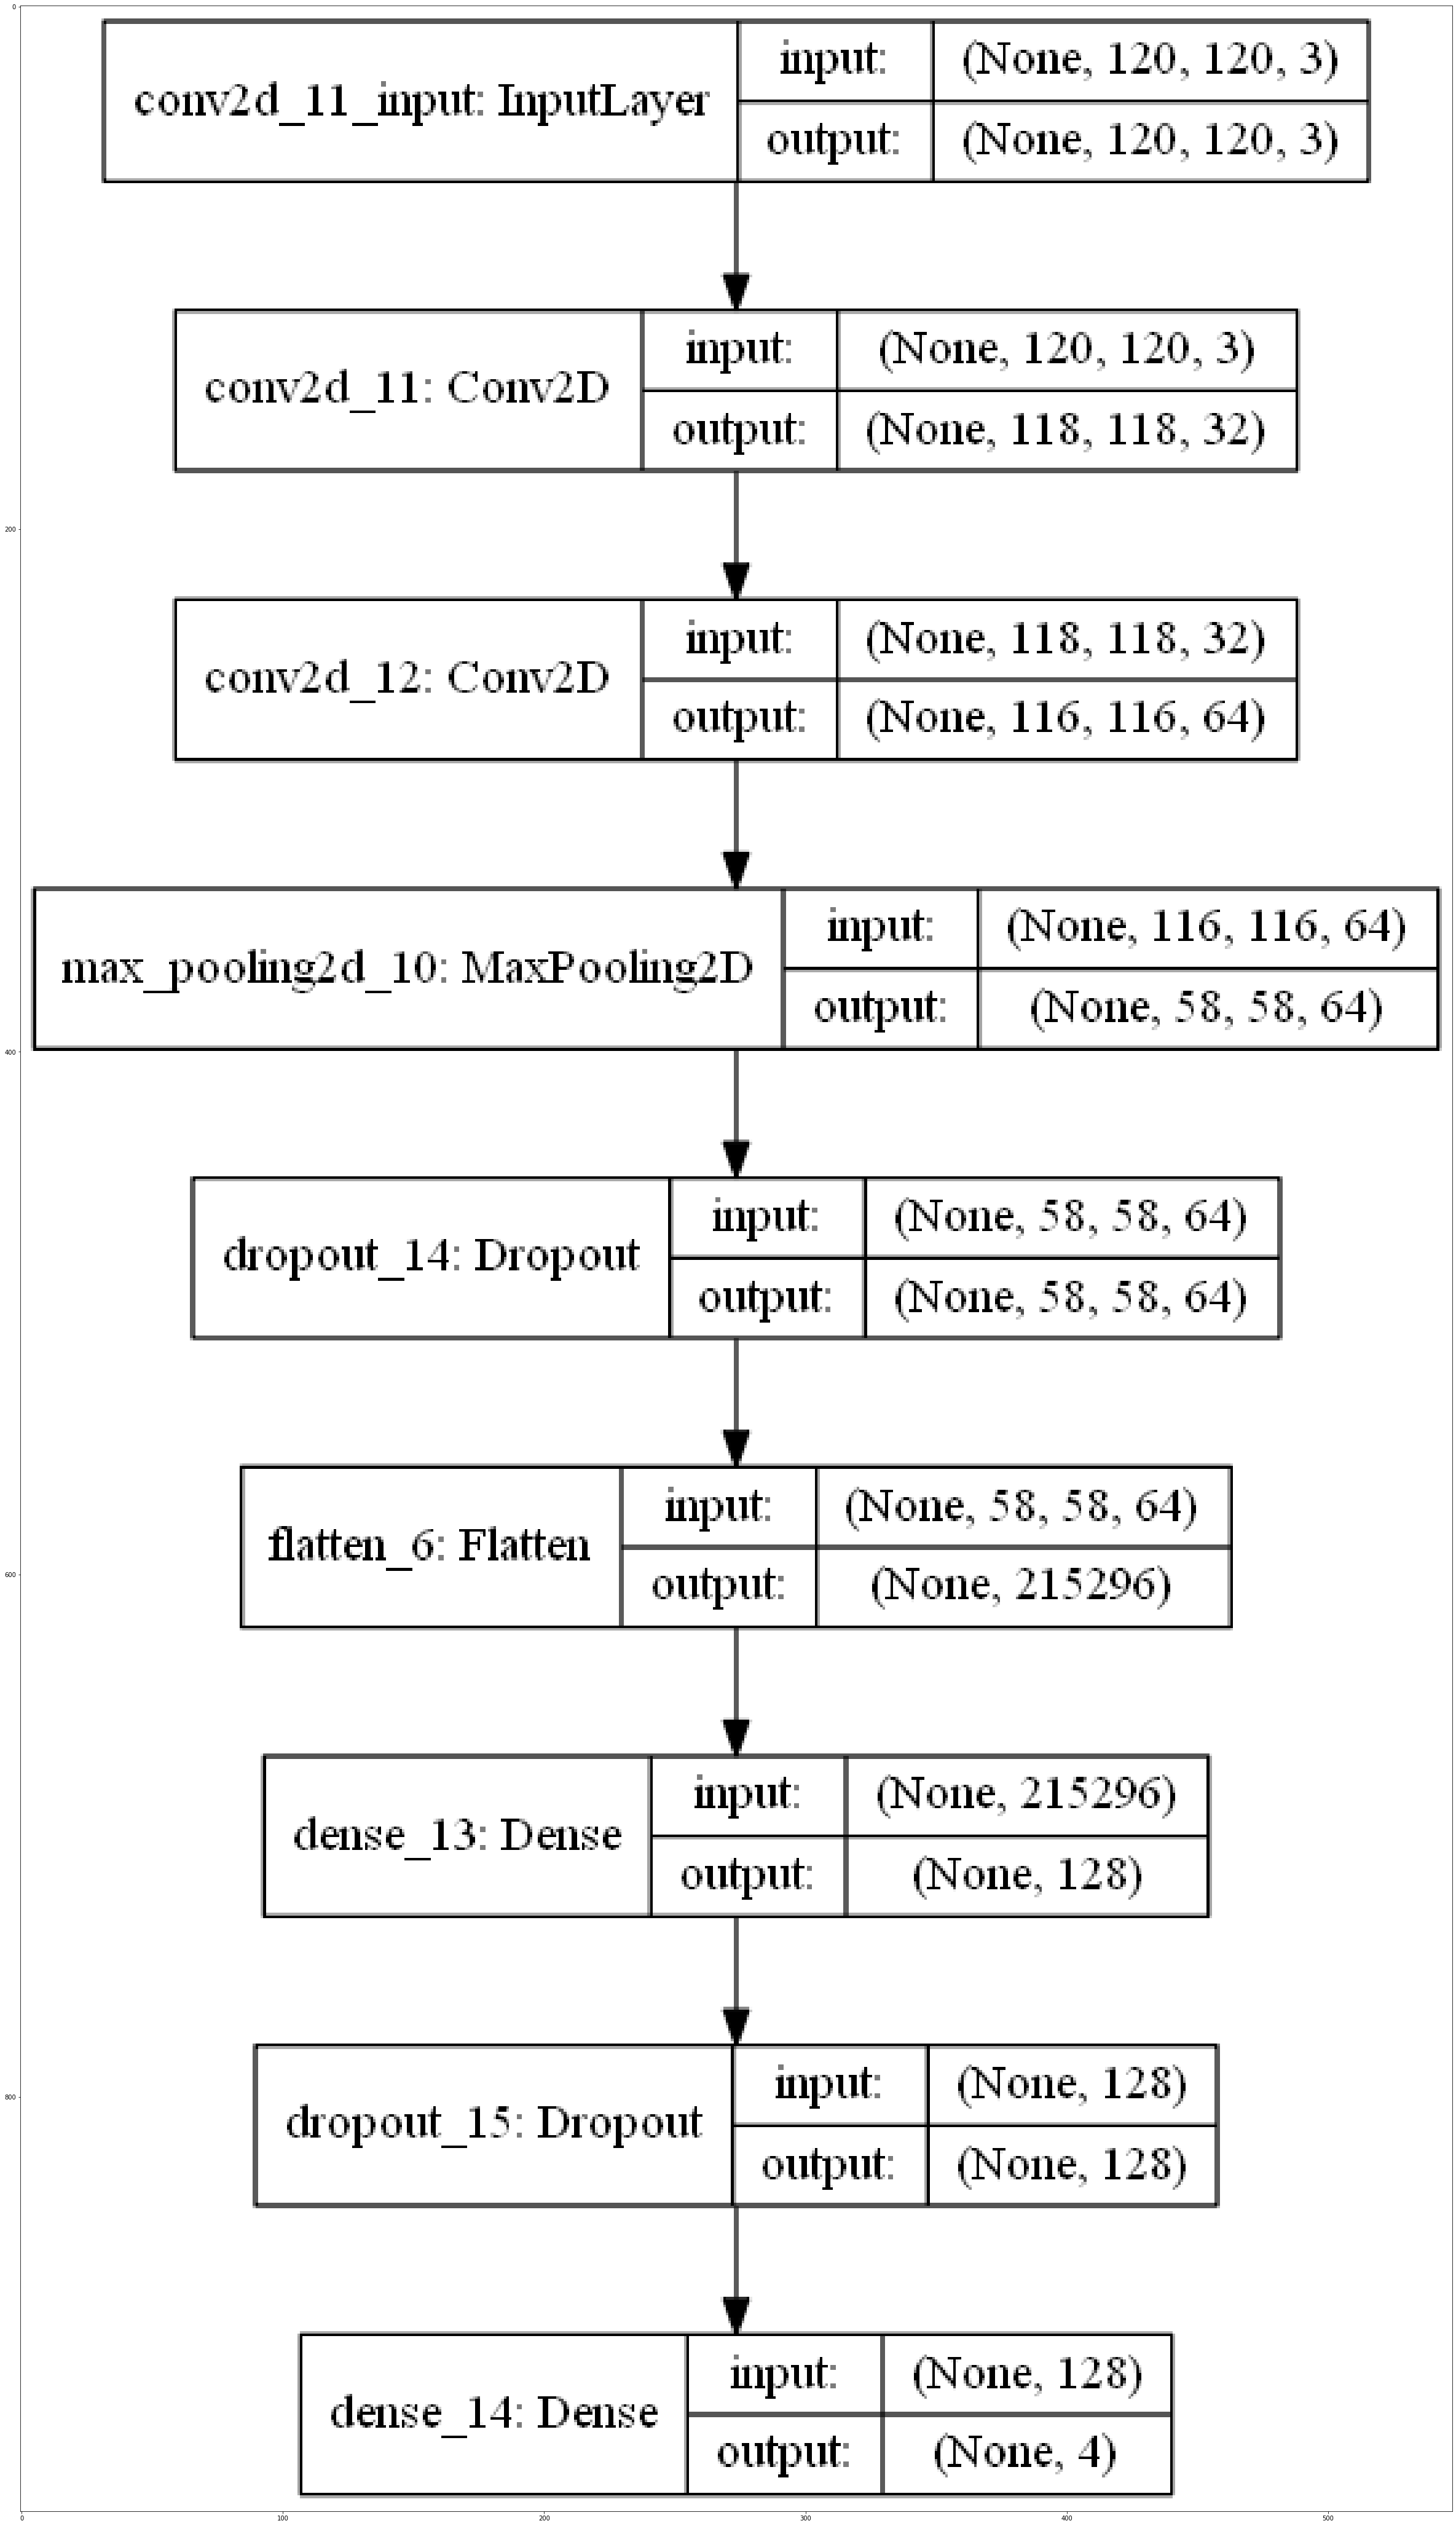

In [35]:
plot_model(model2, to_file='cnn_model_plot.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(75,75))
plt.imshow(plt.imread('cnn_model_plot.png'))

By comparing CNN model with VGG16, we can infer that VGG16 has outperformed the CNN model and can be automated for the blood cell subtype classification.